## Automation of the PathLinker App paper Lovastatin Analysis

## Yihang Xin and Alex Pico

## 2021-01-05

## Setup Cytoscape
* Launch Cytoscape on your local machine. If you haven't already installed Cytoscape, then download the latest version from http://cytoscape.org.
* Install the filetransfer app from https://apps.cytoscape.org/apps/filetransfer
* Install the PathLinker app from http://apps.cytoscape.org/apps/pathlinker
* Leave Cytoscape running in the background during the remainder of the tutorial.
* Check cytoscape connection.

## Import the required packages


In [1]:
import sys
import py4cytoscape as p4c
import networkx as nx
import pandas as pd
import json
import requests

In [2]:
p4c.cytoscape_version_info() # Check cytoscape connection.

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.8.2',
 'automationAPIVersion': '1.0.0',
 'py4cytoscapeVersion': '0.0.6'}

## Create network using networkx
The PathLinker app paper uses the same interactome as the original PathLinker pap (available on the [PathLinker supplementary website](http://bioinformatics.cs.vt.edu/~murali/supplements/2016-sys-bio-applications-pathlinker/) here: [background-interactome-pathlinker-2015.txt](https://raw.githubusercontent.com/Murali-group/PathLinker-Cytoscape/master/src/test/resources/input/graph-dir_human-interactome.txt)).

In [3]:
url = "https://raw.githubusercontent.com/Murali-group/PathLinker-Cytoscape/master/src/test/resources/input/graph-dir_human-interactome.txt"
r = requests.get(url, allow_redirects=True)
open('background-interactome-pathlinker-2015.txt', 'wb').write(r.content)

8914828

In [27]:
# Import/Create the network that PathLinker will run on
network_file = 'background-interactome-pathlinker-2015.txt'

# create a new network by importing the data from a sample using pandas
df = pd.read_csv(network_file, header=None, sep='\t', lineterminator='\n',
                 names=["source", 'target', 'weight', 'evidence'])

# and create the networkx Graph from the pandas dataframe
# this is a directed network, so I'm using the networkx DiGraph instead of the default undirected Graph
G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=['weight'], create_using=nx.MultiDiGraph())

In [28]:
p4c.create_network_from_networkx(G) # Take a while

Applying default style...
Applying preferred layout


{'networkSUID': 51}


## Run PathLinker using the API function
The function takes user sources, targets, and a set of parameters, and computes the k shortest paths. The function returns the paths in JSON format. Based on the user input, the function could generate a subnetwork (and view) containing those paths, and returns the computed paths and subnetwork/view SUIDs.

Additional description of the parameters are available in the PathLinker app [documentation](https://pathlinker-cytoscape-app.readthedocs.io/en/latest/PathLinker_Cytoscape.html#sources-and-targets).

The sources, targets and parameters used below are the same parameters used to run PathLinker in the paper "The PathLinker app: Connect the dots in protein interaction networks".

In [47]:
# Construct input data to pass to PathLinker API function

# construct PathLinker input data parameters for API request
params = {}

# the node names for the sources and targets are space separated 
# and must match the "name" column in the Node Table in Cytoscape
params["sources"] = "P35968 P00533 Q02763"
params["targets"] = "Q15797 Q14872 Q16236 P14859 P36956"

# the number of shortest path to compute, must be greater than 0
# Default: 50
params["k"] = 50

# Edge weight type, must be one of the three: [UNWEIGHTED, ADDITIVE, PROBABILITIES]
params["edgeWeightType"] = "PROBABILITIES" 

# Edge penalty. Not needed for UNWEIGHTED 
# Must be 0 or greater for ADDITIVE, and 1 or greater for PROBABILITIES 
params["edgePenalty"] = 1

# The column name in the Edge Table in Cytoscape containing edge weight property, 
# column type must be numerical type 
params["edgeWeightColumnName"] = "weight"

# The option to ignore directionality of edges when computing paths
# Default: False
params["treatNetworkAsUndirected"] = False

# Allow source/target nodes to appear as intermediate nodes in computed paths
# Default: False
params["allowSourcesTargetsInPaths"] = False

# Include more than k paths if the path length/score is equal to kth path length/score
# Default: False
params["includeTiedPaths"] = False

# Option to disable the generation of the subnetwork/view, path rank column, and result panel
# and only return the path result in JSON format
# Default: False
params["skipSubnetworkGeneration"] = False

In [48]:
cy_network_suid = p4c.get_network_suid()
# perform REST API call
headers = {'Content-Type': 'application/json', 'Accept': 'application/json'}

# construct REST API request url
url = "http://localhost:1234/pathlinker/v1/" + str(cy_network_suid) + "/run"
# to just run on the network currently in view on cytoscape, use the following:
#url = "http://localhost:1234/pathlinker/v1/currentView/run"

# store request output
result_json = requests.request("POST", 
                          url,
                          data = json.dumps(params),
                          params = None,
                          headers = headers)
#print(json.loads(result_json.content))

## Output
The following section stores the subnetwork/view references and prints out the path output returned by the run function.

The output consist of path result in JSON format, and based on user input: subnetwork SUID, subnetwork view SUID, and path rank column name.

In [51]:
# Store result, parse, and print
results = json.loads(result_json.content)

print("Output:\n")

# access the suid, references, and path rank column name
subnetwork_suid = results["subnetworkSUID"]
subnetwork_view_suid = results["subnetworkViewSUID"]
# The path rank column shows for each edge, the rank of the first path in which it appears
path_rank_column_name = results["pathRankColumnName"]
    
print("subnetwork SUID:       %s" % (subnetwork_suid))
print("subnetwork view SUID:  %s" % (subnetwork_view_suid))
print("Path rank column name: %s" % (path_rank_column_name))
print("")

# access the paths generated by PathLinker
paths = results["paths"]

# print the first 10 paths out of 50 paths
for path in paths[:3]:
    print("path rank:  %d" % (path['rank']))
    print("path score: %s" % (str(path['score'])))
    print("path:       %s" % ("|".join(path['nodeList'])))

Output:

subnetwork SUID:       663812
subnetwork view SUID:  663822
Path rank column name: path rank 2

path rank:  1
path score: 0.5625
path:       P00533|P0CG47|Q16236
path rank:  2
path score: 0.5625
path:       P00533|P10275|P14859
path rank:  3
path score: 0.5625
path:       P00533|P10275|Q15797


In [53]:
# write the paths to a file
paths_file = "pathlinker-50-paths.txt"
print("Writing paths to %s" % (paths_file))
with open(paths_file, 'w') as out:
    out.write("path rank\tpath score\tpath\n")
    for path in paths:
        out.write('%d\t%s\t%s\n' % (path['rank'], str(path['score']), "|".join(path['nodeList'])))

Writing paths to pathlinker-50-paths.txt


## View the subnetwork and store the image


In [56]:
p4c.fit_content()
p4c.export_image('pathlinker-50-paths', type='PNG')

This file already exists. A Cytoscape popup will be generated to confirm overwrite.


{'file': '/Users/yxin/CytoscapeConfiguration/filetransfer/default_sandbox/pathlinker-50-paths.png'}

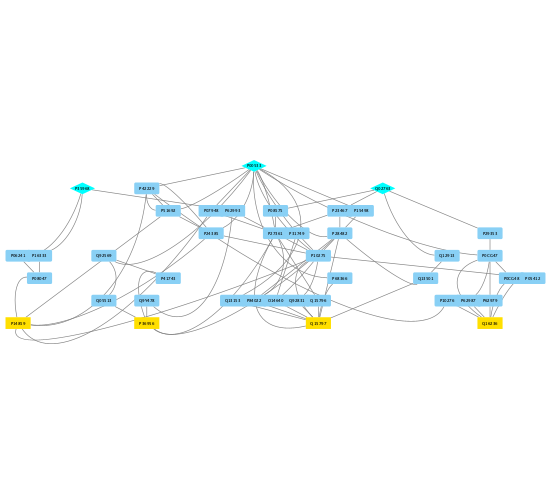

In [58]:
p4c.sandbox_get_from("pathlinker-50-paths.png")
from IPython.display import Image
Image('pathlinker-50-paths.png')